# Deploying ML Models using MLFlow and Sklearn Pipeline

This notebook is demostrated how to use MLflow and Sklearn to deploy ML models into production. 
MLFlow and Sklearn are very virsetile frameworks and there are multiple ways to deploy ML models with them. 
In this notebook I choose to demotrate a pragmatic 


In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from mlflow.models.signature import infer_signature
from mlflow import MlflowClient

from numpy import savetxt
from json import JSONEncoder

import requests
import curl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import os

import mlflow
import mlflow.sklearn


In [2]:
""" Use the house prices dataset for this studynote """

source_dataset = pd.read_csv("../data/House_Price.csv", header=0)

In [3]:
def minimize_dataset(df):
    """ 
    Return a minimized version of the data, 
    to make easy to expirement with feature transformation 
    """

    new_df = pd.DataFrame()

    new_df['price'] = df.price

    # Add new number of hotel rooms to the new df
    new_df['n_hot_rooms'] = df.n_hot_rooms
    
    # Filling missing value in n_hos_beds
    new_df['n_hos_beds'] = df.n_hos_beds

    # Transform the inversely proportional functoin into a liner function using log
    new_df['crime_rate'] = df.crime_rate

    new_df['room_num'] = df.room_num
    new_df['teachers'] = df.teachers
    new_df['waterbody'] = df.waterbody

    new_df['dist1'] = df.dist1
    new_df['dist2'] = df.dist2
    new_df['dist3'] = df.dist3
    new_df['dist4'] = df.dist4
    
    # Convert categorical variables to dummy variables
    #new_df = pd.get_dummies(new_df, drop_first=True)

    return new_df

## Exloring the Data

In [4]:
source_dataset.head()

,price,crime_rate,resid_area,air_qual,room_num,age,dist1,dist2,dist3,dist4,teachers,poor_prop,airport,n_hos_beds,n_hot_rooms,waterbody,rainfall,bus_ter,parks
0,24.0,0.00632,32.31,0.538,6.575,65.2,4.35,3.81,4.18,4.01,24.7,4.98,YES,5.480,11.1920,River,23,YES,0.049347
1,21.6,0.02731,37.07,0.469,6.421,78.9,4.99,4.70,5.12,5.06,22.2,9.14,NO,7.332,12.1728,Lake,42,YES,0.046146
2,34.7,0.02729,37.07,0.469,7.185,61.1,5.03,4.86,5.01,4.97,22.2,4.03,NO,7.394,101.1200,None,38,YES,0.045764
3,33.4,0.03237,32.18,0.458,6.998,45.8,6.21,5.93,6.16,5.96,21.3,2.94,YES,9.268,11.2672,Lake,45,YES,0.047151
4,36.2,0.06905,32.18,0.458,7.147,54.2,6.16,5.86,6.37,5.86,21.3,5.33,NO,8.824,11.2896,Lake,55,YES,0.039474


#### Minimize the data to simplify the examples

In [21]:
df = minimize_dataset(source_dataset)
df.head()

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,dist1,dist2,dist3,dist4
0,24.0,11.1920,5.480,0.00632,6.575,24.7,River,4.35,3.81,4.18,4.01
1,21.6,12.1728,7.332,0.02731,6.421,22.2,Lake,4.99,4.70,5.12,5.06
2,34.7,101.1200,7.394,0.02729,7.185,22.2,None,5.03,4.86,5.01,4.97
3,33.4,11.2672,9.268,0.03237,6.998,21.3,Lake,6.21,5.93,6.16,5.96
4,36.2,11.2896,8.824,0.06905,7.147,21.3,Lake,6.16,5.86,6.37,5.86


### Data Overview
Notes:
- Hospital beds have missing data.
- The distance from employment centers (dist1, dist2...) is similar
- Hi standard diviation for crime_rate
- Waterboy is not numerical

In [6]:
df.describe()

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,dist1,dist2,dist3,dist4
count,506.000000,506.000000,498.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.528854,13.041605,7.899767,3.613524,6.284634,21.544466,3.971996,3.628775,3.960672,3.618972
std,9.182176,5.238957,1.476683,8.601545,0.702617,2.164946,2.108532,2.108580,2.119797,2.099203
min,5.000000,10.057600,5.268000,0.006320,3.561000,18.000000,1.130000,0.920000,1.150000,0.730000
25%,17.025000,11.189800,6.634500,0.082045,5.885500,19.800000,2.270000,1.940000,2.232500,1.940000
50%,21.200000,12.720000,7.999000,0.256510,6.208500,20.950000,3.385000,3.010000,3.375000,3.070000
75%,25.000000,14.170800,9.088000,3.677083,6.623500,22.600000,5.367500,4.992500,5.407500,4.985000
max,50.000000,101.120000,10.876000,88.976200,8.780000,27.400000,12.320000,11.930000,12.320000,11.940000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        506 non-null    float64
 1   n_hot_rooms  506 non-null    float64
 2   n_hos_beds   498 non-null    float64
 3   crime_rate   506 non-null    float64
 4   room_num     506 non-null    float64
 5   teachers     506 non-null    float64
 6   waterbody    506 non-null    object 
 7   dist1        506 non-null    float64
 8   dist2        506 non-null    float64
 9   dist3        506 non-null    float64
 10  dist4        506 non-null    float64
dtypes: float64(10), object(1)
memory usage: 43.6+ KB


In [9]:
# Shortcut functions 

def get_training_testing_data():
    """Function to simplify data splitting"""
    # Prep the data for training and prediction
    if 'price' in df: 
        y = df.pop('price')

    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def eval_metrics(y_true , y_pred):
    """Function to simplfy metrics evaluation"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

## Features Engineering

### Custom Transformer To Aggregate Distance Columns Into One Average Column

In [28]:
class ColumnAvgTransformer(BaseEstimator, TransformerMixin):
    """Custom Transformer To Aggregate Distance Columns Into One Average Column """
    
    def __init__(self,columns, new_column_name):
        self.columns = columns
        self.new_column_name = new_column_name
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        temp_x = X.copy()
        temp_x[self.new_column_name] = temp_x[self.columns].mean(axis=1)
        temp_x = temp_x.drop(self.columns, axis=1)
        return temp_x
    

### Feature Engineering Using SKLearn ColumnTransformer 

In [29]:
## Feature preprocessing

numeric_features = ['n_hot_rooms','n_hos_beds','room_num','teachers']
numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='mean')), ## Fill null cell with mean of the series 
     ('scaler', StandardScaler())]) ## Scale numeric series according to normal distribution

categorical_features = [ 'waterbody']
categorical_transformer = Pipeline(steps=[ 
     ('imputer', SimpleImputer(strategy='constant',fill_value=0)), ## Fill null cell with 0
     ('ordinal_encoder', preprocessing.OrdinalEncoder())]) ## Encode categorical values (Lake = 1, Ocean = 2...)

log_features = ['crime_rate']
log_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='median')),
     ('log_tranformer', FunctionTransformer(np.log1p, validate=True, feature_names_out='one-to-one'))
])

"""
The remainder passthrough let columns that are not specified 
in the ColumnTransfer passthrough 
""" 
preprocessor = ColumnTransformer(
     transformers=[
          ('num', numeric_transformer, numeric_features),
          ('cat', categorical_transformer, categorical_features),
          ('log', log_transformer, log_features)
          ], 
          remainder='passthrough'
     )

preprocessor.set_output(transform="pandas")


ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['n_hot_rooms', 'n_hos_beds', 'room_num',
                                  'teachers']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder())]),
                                 ['waterbody']),
                                ('log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log_tranformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>,
                                                                      validate=True))]),
                                 ['crime_rate'])])

### Training and Evaluating Model without MLFlow
The following cell is an example of the transient nature of model development. 
When a hyperparam changes, the param, and metrics are transient until the following change and run. 

In [30]:
X_train, X_test, y_train, y_test = get_training_testing_data()
X_test

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,dist1,dist2,dist3,dist4
173,23.6,10.1888,9.872,0.09178,6.416,23.4,None,2.86,2.57,2.77,2.39
274,32.4,12.2592,10.648,0.05644,6.758,22.4,River,4.20,3.98,4.38,3.76
491,13.6,14.1088,7.072,0.10574,5.983,19.9,None,1.96,1.69,2.06,1.76
72,22.8,10.1824,5.856,0.09164,6.065,20.8,River,5.46,4.96,5.61,5.12
452,16.1,15.1288,6.722,5.09017,6.297,19.8,None,2.48,2.26,2.37,2.36
...,...,...,...,...,...,...,...,...,...,...,...
412,17.9,15.1432,8.358,18.81100,4.628,19.8,None,1.77,1.54,1.78,1.13
436,9.6,10.0768,6.092,14.42080,6.461,19.8,River,2.32,1.82,2.11,1.75
411,17.2,14.1376,9.644,14.05070,6.657,19.8,None,1.56,1.41,1.66,1.48
86,22.5,11.1800,5.950,0.05188,6.015,21.5,River,4.62,4.16,4.49,4.44


[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.3s
     price  n_hot_rooms  n_hos_beds  crime_rate  room_num  teachers waterbody  \
173   23.6      10.1888       9.872     0.09178     6.416      23.4      None   
274   32.4      12.2592      10.648     0.05644     6.758      22.4     River   
491   13.6      14.1088       7.072     0.10574     5.983      19.9      None   
72    22.8      10.1824       5.856     0.09164     6.065      20.8     River   
452   16.1      15.1288       6.722     5.09017     6.297      19.8      None   
..     ...          ...         ...         ...       ...       ...       ...   
412   17.9      15.1432       8.358    18.81100     4.628      19.8      None   
436    9.6      10.0768       6.092    14.42080     6.461      19.8     River   
411   17.2      14.1376       9.644    14.05070     6.65

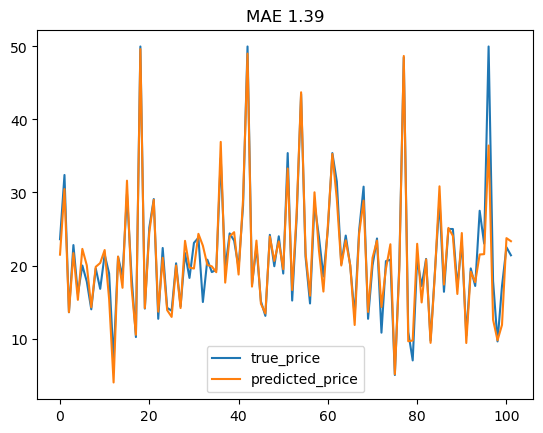

In [31]:
X_train, X_test, y_train, y_test = get_training_testing_data()

params = {'max_depth':13, 'n_estimators':500, 'learning_rate':0.3, 'subsample':0.5, 'colsample_bytree':0.5}
model = Pipeline(steps=[
    ('avg_dist_transformer', ColumnAvgTransformer(['dist1', 'dist2', 'dist3', 'dist4'], 'avg_dist')),
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBRegressor(**params))
    ], verbose=True)


model.fit(X_train, y_train)
print(X_test)
predictions = model.predict(X_test)
print(X_test)
rmse, mae, r2 = eval_metrics(y_pred = predictions, y_true= y_test)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

compare = pd.DataFrame({0:y_test.values, 1:predictions })
compare.columns=['true_price', 'predicted_price']
fig = compare.plot(use_index=True, title = f"MAE {mae:.2f}").get_figure()
fig_file = "true_vs_predicted.png"
fig.savefig(fig_file)

In [32]:
X_test.head()

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,dist1,dist2,dist3,dist4
173,23.6,10.1888,9.872,0.09178,6.416,23.4,None,2.86,2.57,2.77,2.39
274,32.4,12.2592,10.648,0.05644,6.758,22.4,River,4.20,3.98,4.38,3.76
491,13.6,14.1088,7.072,0.10574,5.983,19.9,None,1.96,1.69,2.06,1.76
72,22.8,10.1824,5.856,0.09164,6.065,20.8,River,5.46,4.96,5.61,5.12
452,16.1,15.1288,6.722,5.09017,6.297,19.8,None,2.48,2.26,2.37,2.36


### Deeper Look into Pipeline
Notice that the ML model (classifier) is the last step in a Pipeline. 
A pipeline is a SKLearn class that chain data transformer and classifiers. 
It enables us to package everything needed to run the model. 
This will be useful later on when we deploy this model into production

This pipeline have three steps:
1. 'avg_dist_transformer', ColumnAvgTransformer(['dist1', 'dist2', 'dist3', 'dist4'], 'avg_dist')
2. 'preprocessor', preprocessor 
3. 'classifier', xgb.XGBRegressor(**params)

In [33]:
## Data before entering the pipeline
X_train.head()

,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,dist1,dist2,dist3,dist4
477,12.0,15.0960,9.340,15.02340,5.304,19.8,Lake,2.28,1.99,2.41,1.73
15,19.9,14.1592,8.498,0.62739,5.834,19.0,River,4.60,4.35,4.72,4.32
332,19.4,14.1552,7.488,0.03466,6.031,23.1,None,6.95,6.58,6.80,6.23
423,13.4,81.1200,8.268,7.05042,6.103,19.8,Lake,2.08,1.80,2.34,1.87
19,18.2,12.1456,8.564,0.72580,5.727,19.0,Lake and River,3.98,3.65,4.00,3.57


In [34]:
## Data looks after first step. Notice the new avg_dist column 
model[0:1].fit_transform(X_train)

[Pipeline]  (step 1 of 1) Processing avg_dist_transformer, total=   0.0s


,price,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,avg_dist
477,12.0,15.0960,9.340,15.02340,5.304,19.8,Lake,2.1025
15,19.9,14.1592,8.498,0.62739,5.834,19.0,River,4.4975
332,19.4,14.1552,7.488,0.03466,6.031,23.1,None,6.6400
423,13.4,81.1200,8.268,7.05042,6.103,19.8,Lake,2.0225
19,18.2,12.1456,8.564,0.72580,5.727,19.0,Lake and River,3.8000
...,...,...,...,...,...,...,...,...
106,19.5,14.1560,10.290,0.17120,5.836,19.1,Lake,2.2100
270,21.1,15.1688,6.222,0.29916,5.856,21.4,None,4.4300
348,24.5,13.1960,6.290,0.01501,6.635,23.0,None,8.3425
435,13.4,12.1072,10.168,11.16040,6.629,19.8,Lake and River,2.1250


In [35]:
## Data after the second step. Nutice the numeric values are scaled and categorical (waterbody) data is numeric
model[0:2].fit_transform(X_train)

[Pipeline]  (step 1 of 2) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing preprocessor, total=   0.0s


,num__n_hot_rooms,num__n_hos_beds,num__room_num,num__teachers,cat__waterbody,log__crime_rate,remainder__price,remainder__avg_dist
477,0.592920,0.958632,-1.428069,-0.845343,0.0,2.774050,12.0,2.1025
15,0.345531,0.383383,-0.680087,-1.204741,3.0,0.486978,19.9,4.4975
332,0.344475,-0.306642,-0.402063,0.637176,2.0,0.034073,19.4,6.6400
423,18.028479,0.226249,-0.300450,-0.845343,0.0,2.085724,13.4,2.0225
19,-0.186219,0.428474,-0.831094,-1.204741,1.0,0.545691,18.2,3.8000
...,...,...,...,...,...,...,...,...
106,0.344686,1.607666,-0.677264,-1.159817,0.0,0.158029,19.5,2.2100
270,0.612145,-1.171565,-0.649038,-0.126546,2.0,0.261718,21.1,4.4300
348,0.091170,-1.125108,0.450354,0.592251,2.0,0.014898,24.5,8.3425
435,-0.196359,1.524317,0.441886,-0.845343,1.0,2.498185,13.4,2.1250


## Tracking Expirements with MLFlow

In [16]:
## Setting global variables
MODEL_ARTIFACTS_PATH = "skl_pipe_xgb_house_prices_path"
EXPERIMENT_NAME = "house_prices_sklearn_pipe_xgb_2"

## Tell MLFlow where is the tracking server
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(EXPERIMENT_NAME)
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print("experiment_id:", experiment.experiment_id)


experiment_id: 15


[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.8s


Registered model 'house_prices_xgb_model' already exists. Creating a new version of this model...
2023/03/27 10:04:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model, version 54
Created version '54' of model 'house_prices_xgb_model'.


run_uri - runs:/4b99f572e21349f8b6c63a568e4418bf MAE: 0.554840238421571
[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.8s


Registered model 'house_prices_xgb_model' already exists. Creating a new version of this model...
2023/03/27 10:04:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model, version 55
Created version '55' of model 'house_prices_xgb_model'.


run_uri - runs:/5211bb5224354641a2618b7573776746 MAE: 0.9214175813338339
[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.3s


Registered model 'house_prices_xgb_model' already exists. Creating a new version of this model...
2023/03/27 10:04:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model, version 56
Created version '56' of model 'house_prices_xgb_model'.


run_uri - runs:/136a845504a042fbb32e230e924ed08a MAE: 1.0009840759576536
[Pipeline]  (step 1 of 3) Processing avg_dist_transformer, total=   0.0s
[Pipeline] ...... (step 2 of 3) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.5s


Registered model 'house_prices_xgb_model' already exists. Creating a new version of this model...
2023/03/27 10:04:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house_prices_xgb_model, version 57
Created version '57' of model 'house_prices_xgb_model'.


run_uri - runs:/eb46c31c2dc7438384160b68a0ff6709 MAE: 0.45961668725107235


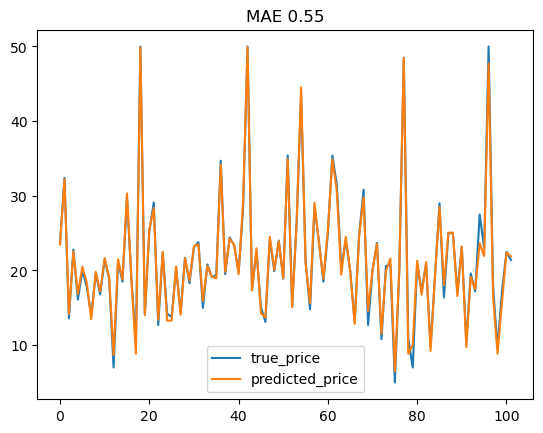

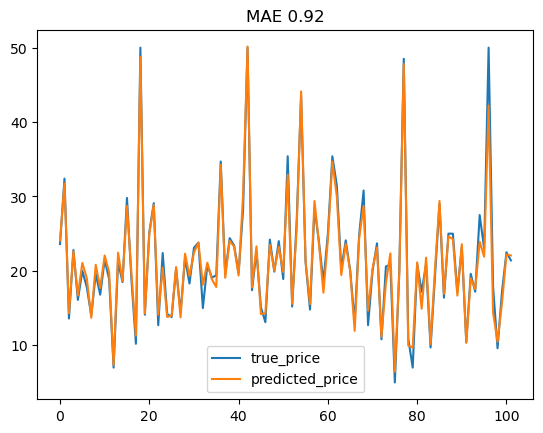

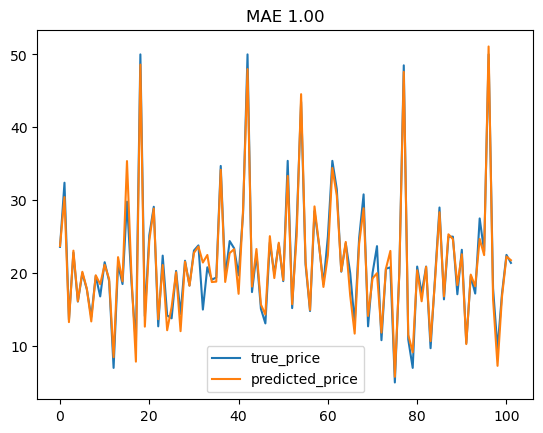

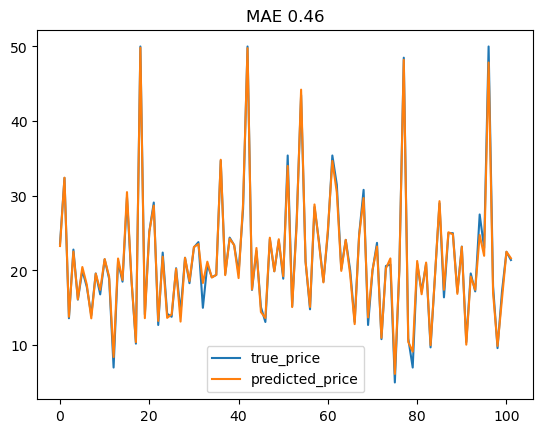

In [36]:
## Get Training Data
X_train, X_test, y_train, y_test = get_training_testing_data()

# List of different hyperparams to expirement. This is pretty manual example for the purpose to demotrating how the different
# runs hyperparams looks like in the mlflow UI. 
params_list = [
    {'max_depth':20, 'n_estimators':1000, 'learning_rate':0.05, 'subsample':1.0, 'colsample_bytree':0.8},
    {'max_depth':12, 'n_estimators':1000, 'learning_rate':0.1, 'subsample':0.5, 'colsample_bytree':0.5},
    {'max_depth':5, 'n_estimators':1000, 'learning_rate':0.5, 'subsample':0.8, 'colsample_bytree':0.8},
    {'max_depth':12, 'n_estimators':1000, 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8}
]

for params in params_list:
    with mlflow.start_run() as model_tracking_run:

        """ 
        Log model params in MLFlow
        Example of param dict: {'max_depth':12, 'n_estimators':1000, 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8}
        """
        mlflow.log_params(params)

        """
        The pipeline is composed of three parts. 
        1. Custom transformer that modify the shape of the dataframe.
        2. Preprocesor that generate features by filling null values and replace categorical values with numbers
        3. The estimator model
        Git notebook on github for the preprocessor and transformer code
        """
        model = Pipeline(steps=[
            ('avg_dist_transformer', ColumnAvgTransformer(['dist1', 'dist2', 'dist3', 'dist4'], 'avg_dist')),
            ('preprocessor', preprocessor),
            ('classifier', xgb.XGBRegressor(**params))
        ], verbose=True)
        
        # Fit execute the transformer, preprocessor and estimator 
        model.fit(X_train, y_train)

        predictions = model.predict(X_test)

        # mlflow generates the model signtur. What paramaters the model expects, and what does it return. 
        model_signature = infer_signature(X_train, predictions)

        ## Log model in MLFlow - registered_model_name = "house_prices_xgb_model"
        mlflow.sklearn.log_model(sk_model = model, 
            artifact_path=MODEL_ARTIFACTS_PATH,
            registered_model_name = "house_prices_xgb_model",
            signature = model_signature)

        rmse, mae, r2 = eval_metrics(y_test, predictions)

        # log model performance
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)

        # Print the run id
        run_uri = f"runs:/{model_tracking_run.info.run_id}"
        print(f"run_uri - {run_uri} MAE: {mae}")

        # Store run artifacts in the local file system and log into the tracking server
        # This creates /path/where/notebook/run/artifacts_store/run_0287c883ffdc406bbffa91b5eef156dc
        local_artifacts_store_path = f"artifacts_store/run_{model_tracking_run.info.run_id}"
        os.makedirs(local_artifacts_store_path)

        ## Save and log predicted values
        prediction_file = f"{local_artifacts_store_path}/prediction.csv"
        savetxt(prediction_file, predictions)
        
        mlflow.log_artifact(prediction_file)

        ## Create a plot that shows predicted vs true prices
        compare = pd.DataFrame({0:y_test.values, 1:predictions })
        compare.columns=['true_price', 'predicted_price']
        fig = compare.plot(use_index=True, title = f"MAE {mae:.2f}").get_figure()
        fig_file = f"{local_artifacts_store_path}/true_vs_predicted.png"
        fig.savefig(fig_file)
        
        mlflow.log_artifact(fig_file)

        """
        Example of finel run artifacts on the file system
        ls -l /path/where/notebook/run/artifacts_store/run_0287c883ffdc406bbffa91b5eef156dc
        prediction.csv
        true_vs_predicted.png
        """




## Deploy the Winning Run
Looking at the MLFlow UI, we determined the winning run model and decided to deploy it. 
For example, let's say we want to deploy the model name "house_prices_xgb_model" version 33. 

The following two functions will use the model name and version to retrieve its metadata 
and generate a bash script that serves the prediction endpoint. 

In [37]:
client = MlflowClient()

def get_model_metadata(model_name: str, version: int) -> dict:
    """ Function to find the model version and return key metadata"""
    mv = client.get_model_version(name=model_name, version=version)
    if mv is not None:
        meta = dict()
        meta['stage'] = mv.current_stage
        meta['model_name'] = mv.name
        meta['model_version'] = mv.version
        meta['model_uri'] = f"models:/{model_name}/{version}"
        return meta

    else:
        print(f"Can't find model version for {model_name} state {stage}")
        return None

In [38]:

def write_bash_deployment_script(model_name: str, version: int, port: int) -> dict:
    meta = get_model_metadata(model_name, version)
    filename = f"deploy_{model_name}_version_{version}.sh"
    model_uri = meta['model_uri']

    with open(filename, 'w') as f:
        f.write('#!/bin/bash\n\n')
        f.write('export MLFLOW_TRACKING_URI=http://localhost:5000\n')
        f.write(f'mlflow models serve -m "{model_uri}" -p {port}\n')
    
    meta['deployment_script'] = filename

    return meta


The function call below will generate a bash file. The `mlflow models serve` deploy the model into an endpoint. 
The script need to run from terminal. 

`#!/bin/bash`

`export MLFLOW_TRACKING_URI=http://localhost:5000`

`mlflow models serve -m "models:/house_prices_xgb_model/33" -p 8002`

In [39]:
meta = write_bash_deployment_script('house_prices_xgb_model', 57, 8002)

### Test Model Endpoint and Update Model Registry with Stage and Decription 

In [41]:
def test_model_deployment(meta: dict, target_stage: str, port: int, test_df: pd.DataFrame):
    """Test model deployment, transition model stage and add curl example to description"""
    host = '0.0.0.0'
    url = f'http://{host}:{port}/invocations'
    headers = {
        'Content-Type': 'application/json',
    }
    http_data = test_df.to_dict('records')

    payload = JSONEncoder().encode({"dataframe_records": [http_data[0]]})

    response = requests.post(url=url, headers=headers, data=payload)

    if response.status_code == 200:
        print(f'Predictions: {response.text}')

        meta['stage'] = target_stage

        client.transition_model_version_stage(
            name = meta['model_name'], 
            version = meta['model_version'], 
            stage = meta['stage'], 
            archive_existing_versions = True)

        ## Generate curl example
        curl_string = curl.parse(response, return_it=True)

        ## Add curl code example   
        client.update_model_version(
            name = meta['model_name'],
            version = meta['model_version'],
            description = f"Model is in production.\n Example of curl calling it:\n\n {curl_string}"
        )
    else:
        print("Something didn't work :(")

In [42]:
test_model_deployment(meta, 'Production', 8002, X_test)

Predictions: {"predictions": [23.273860931396484]}
curl -X POST -H 'Accept: */*' -H 'Accept-Encoding: gzip, deflate, br' -H 'Connection: keep-alive' -H 'Content-Type: application/json' -H 'User-Agent: python-requests/2.28.1' -d '{"dataframe_records": [{"price": 23.6, "n_hot_rooms": 10.1888, "n_hos_beds": 9.872, "crime_rate": 0.09178, "room_num": 6.416, "teachers": 23.4, "waterbody": "None", "dist1": 2.86, "dist2": 2.57, "dist3": 2.77, "dist4": 2.39}]}' http://0.0.0.0:8002/invocations


In [20]:
X_test

,n_hot_rooms,n_hos_beds,crime_rate,room_num,teachers,waterbody,dist1,dist2,dist3,dist4,avg_dist
173,10.1888,9.872,0.09178,6.416,23.4,None,2.86,2.57,2.77,2.39,2.6475
274,12.2592,10.648,0.05644,6.758,22.4,River,4.20,3.98,4.38,3.76,4.0800
491,14.1088,7.072,0.10574,5.983,19.9,None,1.96,1.69,2.06,1.76,1.8675
72,10.1824,5.856,0.09164,6.065,20.8,River,5.46,4.96,5.61,5.12,5.2875
452,15.1288,6.722,5.09017,6.297,19.8,None,2.48,2.26,2.37,2.36,2.3675
...,...,...,...,...,...,...,...,...,...,...,...
412,15.1432,8.358,18.81100,4.628,19.8,None,1.77,1.54,1.78,1.13,1.5550
436,10.0768,6.092,14.42080,6.461,19.8,River,2.32,1.82,2.11,1.75,2.0000
411,14.1376,9.644,14.05070,6.657,19.8,None,1.56,1.41,1.66,1.48,1.5275
86,11.1800,5.950,0.05188,6.015,21.5,River,4.62,4.16,4.49,4.44,4.4275


In [94]:
client.search_registered_models()[0].latest_versions[0].current_stage

'Staging'

In [96]:
for x in client.search_registered_models():
    for v in x.latest_versions:
        if(v.current_stage == 'Production'):
            print(v)


<ModelVersion: creation_timestamp=1678291325423, current_stage='Production', description='', last_updated_timestamp=1678802611916, name='house_prices_xgb_model', run_id='b49fecb8dddd4b338589019620d9e391', run_link='', source='mlflow-artifacts:/13/b49fecb8dddd4b338589019620d9e391/artifacts/skl_pipe_xgb_house_prices_path', status='READY', status_message='', tags={'workflow_status': 'ready_to_deploy'}, user_id='', version='26'>
<ModelVersion: creation_timestamp=1678200149223, current_stage='Production', description='', last_updated_timestamp=1678200185239, name='house_prices_xgb_model_2', run_id='b30684b9988d4ac9922e7951cb917285', run_link='', source='mlflow-artifacts:/13/b30684b9988d4ac9922e7951cb917285/artifacts/skl_pipe_xgb_house_prices_path', status='READY', status_message='', tags={}, user_id='', version='2'>


In [88]:
mod = client.get_latest_versions(name='house_prices_xgb_model', stages=['Production'])
stage = mod[0].current_stage
model_name = mod[0].name
model_version = mod[0].version
model_uri = f"models:/{model_name}/{stage}"


In [89]:
model = mlflow.pyfunc.load_model(model_uri=model_uri)

In [90]:
model.predict(X_test)

array([24.603153, 28.107718, 17.672958, 22.748083, 16.449049, 21.914537,
       20.597105, 16.05449 , 20.819206, 19.060219, 23.389862, 21.102917,
       10.662875, 23.35479 , 19.88358 , 31.891035, 19.53078 , 12.214203,
       46.460762, 12.234445, 24.093327, 25.738014, 14.367549, 23.154089,
       13.307511, 14.143207, 20.119034, 14.066874, 20.871758, 20.339136,
       20.501945, 23.462294, 27.143982, 17.654808, 20.408737, 18.113434,
       31.844736, 19.810589, 22.208952, 21.096193, 16.35138 , 29.408743,
       49.508648, 18.817581, 25.46473 , 14.9403  , 14.939941, 24.499557,
       21.433699, 25.232878, 20.22166 , 33.231144, 15.746215, 27.505695,
       48.162197, 19.571148, 16.486546, 30.553553, 23.937496, 19.33612 ,
       23.126354, 31.837347, 25.877449, 15.663997, 25.481295, 16.56734 ,
       10.606483, 25.563244, 23.928228, 19.552847, 20.045582, 23.794916,
       13.230323, 17.51215 , 25.637651,  9.655105, 18.946684, 47.042786,
        8.289777, 16.327541, 21.547878, 15.432724, 

In [91]:
mlflow.sklearn.save_model(model, "saved_model")